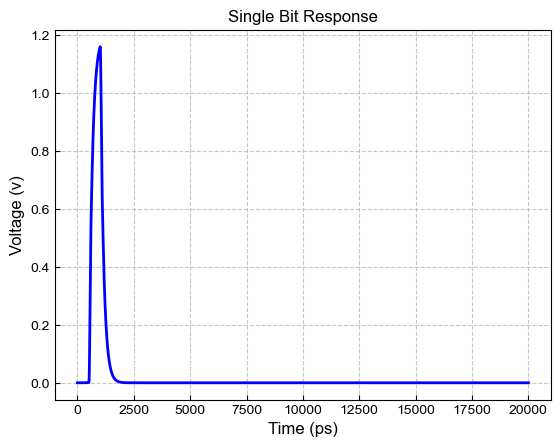

交点: [-0.9597864641320448, 496.7877795382653]
两交点之间的距离: 497.7475661405146


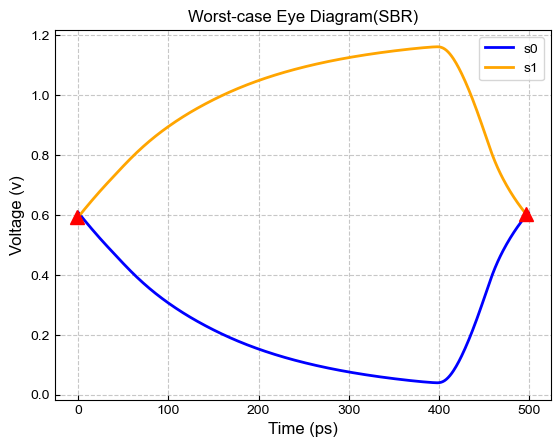

eh: 1.1216733160637267
ew: 497.7475661405146


In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt

def read_time_voltage_file(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line and not line.startswith('#'):
                if not data:  # 第一行表示名称
                    data.append(('Name', line))
                else:
                    time, voltage = line.split()
                    data.append((float(time), float(voltage)))
    return data

def locate_main_cursor(time, voltage, N):
    max_voltage = max(voltage)
    max_voltage_index = voltage.index(max_voltage)
    ui_diff = 1e6
    ndx = max_voltage_index
    while(ui_diff > 0):
        ndx = ndx + 1
        ui_diff = voltage[ndx] - voltage[ndx - N]
    main_cursor_index_right = ndx
    main_cursor_index_left = ndx - N    
    return main_cursor_index_left, main_cursor_index_right

def shift_pulse(voltages, main_cursor_index_left, N):
    voltages = np.array(voltages)
    shift_1 = N - (main_cursor_index_left % N)
    shifted_voltages = np.roll(voltages, shift_1)
    return shifted_voltages, shift_1

def find_intersection(s0, s1):
    diff = s1 - s0
    zero_crossings = np.where(np.diff(np.sign(diff)))[0]
    intersections = []
    for index in zero_crossings:
        x0, y0 = index, s1[index]
        x1, y1 = index + 1, s1[index + 1]
        # 线性插值
        x_intersect = x0 + (y0 - s0[index]) * (x1 - x0) / (y1 - y0)
        intersections.append(x_intersect)
    return intersections

def calculate_distance(point1, point2):
    """计算两点之间的距离"""
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

filename_ads = 'E:\\20250118\\sbr_data.txt'  
data_ads = read_time_voltage_file(filename_ads)
times_1 = [entry[0] for entry in data_ads[1:]]
voltages_1 = [entry[1] for entry in data_ads[1:]]

# 美化图像
plt.figure()

plt.plot(voltages_1, color='blue', linewidth=2)


plt.title('Single Bit Response', fontsize=12, fontname='Arial')
plt.xlabel('Time (ps)', fontsize=12, fontname='Arial')
plt.ylabel('Voltage (v)', fontsize=12, fontname='Arial')
plt.xticks(fontname='Arial')
plt.yticks(fontname='Arial')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().tick_params(direction='in')  # 刻度朝内
# plt.legend(fontsize=12, prop='Arial')
plt.show()

mc_left_index, mc_right_index = locate_main_cursor(times_1, voltages_1, 500)
shifted_voltages, shift1 = shift_pulse(voltages_1, mc_left_index, 500)
mc_left_index += shift1
mc_right_index += shift1

main_cursor_v = shifted_voltages[mc_left_index:mc_right_index]
pre_cursor_v = shifted_voltages[0:mc_left_index]
post_cursor_v = shifted_voltages[mc_right_index:]

pre_cursor_v = pre_cursor_v.reshape(-1, 500)
N = 500
nsym_post_cursor = math.floor(len(post_cursor_v) / N)
post_cursor_v = post_cursor_v[0:N * nsym_post_cursor].reshape(-1, 500)

upperPattern_pre = pre_cursor_v < 0
lowerPattern_pre = pre_cursor_v > 0
upperPattern_post = post_cursor_v < 0
lowerPattern_post = post_cursor_v > 0

s1 = np.sum(pre_cursor_v * upperPattern_pre, axis=0) + np.sum(post_cursor_v * upperPattern_post, axis=0) + main_cursor_v
s0 = np.sum(pre_cursor_v * lowerPattern_pre, axis=0) + np.sum(post_cursor_v * lowerPattern_post, axis=0)

# 找到交点
intersections = find_intersection(s0, s1)
print("交点:", intersections)

# 计算交点的距离
if len(intersections) >= 2:
    point1 = (intersections[0], s1[int(intersections[0])])
    point2 = (intersections[1], s1[int(intersections[1])])
    distance = calculate_distance(point1, point2)
    print("两交点之间的距离:", distance)

# 美化图像
plt.figure()
plt.plot(s0, label='s0', color='blue', linewidth=2)
plt.plot(s1, label='s1', color='orange', linewidth=2)
for x in intersections:
    plt.plot(x, s1[int(x)], 'r^',markersize = 10)  # 在交点处标记红点

plt.title('Worst-case Eye Diagram(SBR)', fontsize=12, fontname='Arial')
plt.xlabel('Time (ps)', fontsize=12, fontname='Arial')
plt.ylabel('Voltage (v)', fontsize=12, fontname='Arial')
plt.xticks(fontname='Arial')
plt.yticks(fontname='Arial')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().tick_params(direction='in')  # 刻度朝内
plt.legend(fontsize=20, prop='Arial')
plt.show()
eh = s1 - s0
eh = max(eh)
ew = distance
print("eh:",eh)
print("ew:",ew)